In [1]:
from pathlib import Path
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np
import seaborn as sns
import spacy
from matplotlib import pyplot as plt
from joblib import Parallel, delayed

from src.gen.util import read_gzip_data, write_gzip_data

datap = Path("/users/k21190024/study/fact-check-transfer-learning/scratch/dumps/data/level/2")
dumpp = Path("/users/k21190024/study/fact-check-transfer-learning/scratch/dumps/explore/level/2")
if not dumpp.exists():
    dumpp.mkdir(parents=True)

# General Functions

In [2]:
def unpack_fever_corpus(res):
    return [{"fever-corpus-evidence": np.concatenate(tuple(list(i.values())[0] for i in res))}]

def unpack_dfls(res):
    unlist = []
    for r in res:
        if len(r) > 1:
            if isinstance(r, dict):
                for i in r:
                    unlist.append({i: r[i]})
        else:
            unlist.append(r)
    return unlist

# Load data

In [3]:
cla = "claims_lemma.pkl.gz"
cor = "corpus_lemma.pkl.gz"

# Explore

In [7]:
fls = [
    datap.joinpath("scifact", cla), datap.joinpath("scifact", cor)
    , datap.joinpath("fever", cla)#, datap.joinpath("fever", cor)
    , datap.joinpath("climatefever", cla), datap.joinpath("climatefever", cor)
]

fever_cor = datap.joinpath("fever", "part")
fever_n_jobs = 30

## Lemma per doc

In [6]:
def lemma_per_doc(fp):
    ls = read_gzip_data(fp)
    res = {}
    for k, v in ls.items():
        if k == "ner":
            continue
        res[f"{fp.parent.name}-{fp.name.split('_')[0]}-{k}"] = np.array([len(l) for l in v])
    return res

res_ls = (
    unpack_dfls(Parallel(n_jobs=len(fls))(delayed(lemma_per_doc)(fp) for fp in fls)) 
    + unpack_fever_corpus(Parallel(n_jobs=fever_n_jobs)(delayed(lemma_per_doc)(fp) for fp in fever_cor.iterdir()))
)

def lemma_stats(res):
    doc = list(res.keys())[0]
    lemmas = list(res.values())[0]
    return {
        "dataset": doc,
        "mean": np.mean(lemmas),
        "median": np.median(lemmas),
        "min": np.min(lemmas),
        "max": np.max(lemmas),
    }

df_lempd = Parallel(n_jobs=len(res_ls))(delayed(lemma_stats)(r) for r in res_ls)
df_lempd = pd.DataFrame(df_lempd)
df_lempd

,dataset,mean,median,min,max
0,scifact-claims-claims,8.750887,8.0,3,23
1,scifact-corpus-title,9.666795,9.0,0,33
2,scifact-corpus-evidence,126.049778,119.0,20,898
3,fever-claims-claims,5.000782,5.0,0,54
4,climatefever-claims-claims,10.995440,10.0,4,38
5,climatefever-corpus-title,7.154397,7.0,1,18
6,climatefever-corpus-evidence,15.109446,14.0,1,172
7,fever-corpus-evidence,47.787410,31.0,0,29148


## Lemma histogram

In [21]:
def counter_lemmas(fp):
    f = read_gzip_data(fp)
    res = {}
    for k, v in f.items():
        if k == "ner":
            continue
        flatls = []
        for i in v:
            flatls += i
        res[f"{fp.parent.name}-{fp.name.split('_')[0]}-{k}"] = Counter(flatls)
    return res
        
def reduce_fever_counter(fcounter):
    gen_f = iter(fcounter)
    res = next(gen_f)
    res = list(res.values())[0]
    for r in gen_f:
        tmp = list(r.values())[0]
        res.update(tmp)
    return [{"fever-corpus-evidence": res}]
    
lemma_counter = (
    unpack_dfls(Parallel(n_jobs=len(fls))(delayed(counter_lemmas)(fp) for fp in fls))
    + reduce_fever_counter(Parallel(n_jobs=fever_n_jobs)(delayed(counter_lemmas)(fp) for fp in fever_cor.iterdir()))
)

In [72]:
df_words = pd.DataFrame(columns=["dataset", "lemma", "count"])
for d in lemma_counter:
    tv = dict(list(d.values())[0])
    tmpdf = pd.DataFrame(list(tv.items()), columns=["lemma", "count"])
    tmpdf["dataset"] = list(d.keys())[0]
    df_words = pd.concat([df_words, tmpdf], axis=0)
    
df_words = df_words.reset_index(drop=True)
# 4099287 rows

df_words = df_words.loc[
    ~df_words["lemma"].str.contains(r"lrb", case=False)
    & ~df_words["lemma"].str.contains(r"rrb", case=False)
    & ~df_words["lemma"].str.contains(r"\+\d*\.?\d*", case=False)
]
# 4096289 rows

In [73]:
df_words = df_words.merge(
    df_words.groupby("dataset", as_index=False)["count"].sum().rename({"count": "total_count"}, axis=1)
    , on="dataset"
)
df_words["normalised_count"] = df_words["count"] / df_words["total_count"] * 100
df_words

,dataset,lemma,count,total_count,normalised_count
0,scifact-claims-claims,dimensional,2,12318,0.016236
1,scifact-claims-claims,biomaterial,2,12318,0.016236
2,scifact-claims-claims,lack,19,12318,0.154246
3,scifact-claims-claims,inductive,2,12318,0.016236
4,scifact-claims-claims,property,2,12318,0.016236
...,...,...,...,...,...
4096284,fever-corpus-evidence,intermediate-2,1,246816481,0.0
4096285,fever-corpus-evidence,Chōtatsurō,2,246816481,0.000001
4096286,fever-corpus-evidence,Issalissekine,1,246816481,0.0
4096287,fever-corpus-evidence,Ingvariella,2,246816481,0.000001


In [74]:
df_topwords = (
    df_words
    .sort_values(["dataset", "count"], ascending=[True, False])
    .groupby("dataset", as_index=False)
    .head(10)
)
df_topwords

,dataset,lemma,count,total_count,normalised_count
79693,climatefever-claims-claims,warming,329,16878,1.949283
79692,climatefever-claims-claims,global,318,16878,1.884109
79782,climatefever-claims-claims,climate,301,16878,1.783387
79736,climatefever-claims-claims,temperature,245,16878,1.451594
79768,climatefever-claims-claims,year,203,16878,1.202749
...,...,...,...,...,...
3410,scifact-corpus-title,induce,260,50074,0.519232
3772,scifact-corpus-title,disease,249,50074,0.497264
3246,scifact-corpus-title,stem,245,50074,0.489276
3486,scifact-corpus-title,patient,240,50074,0.479291


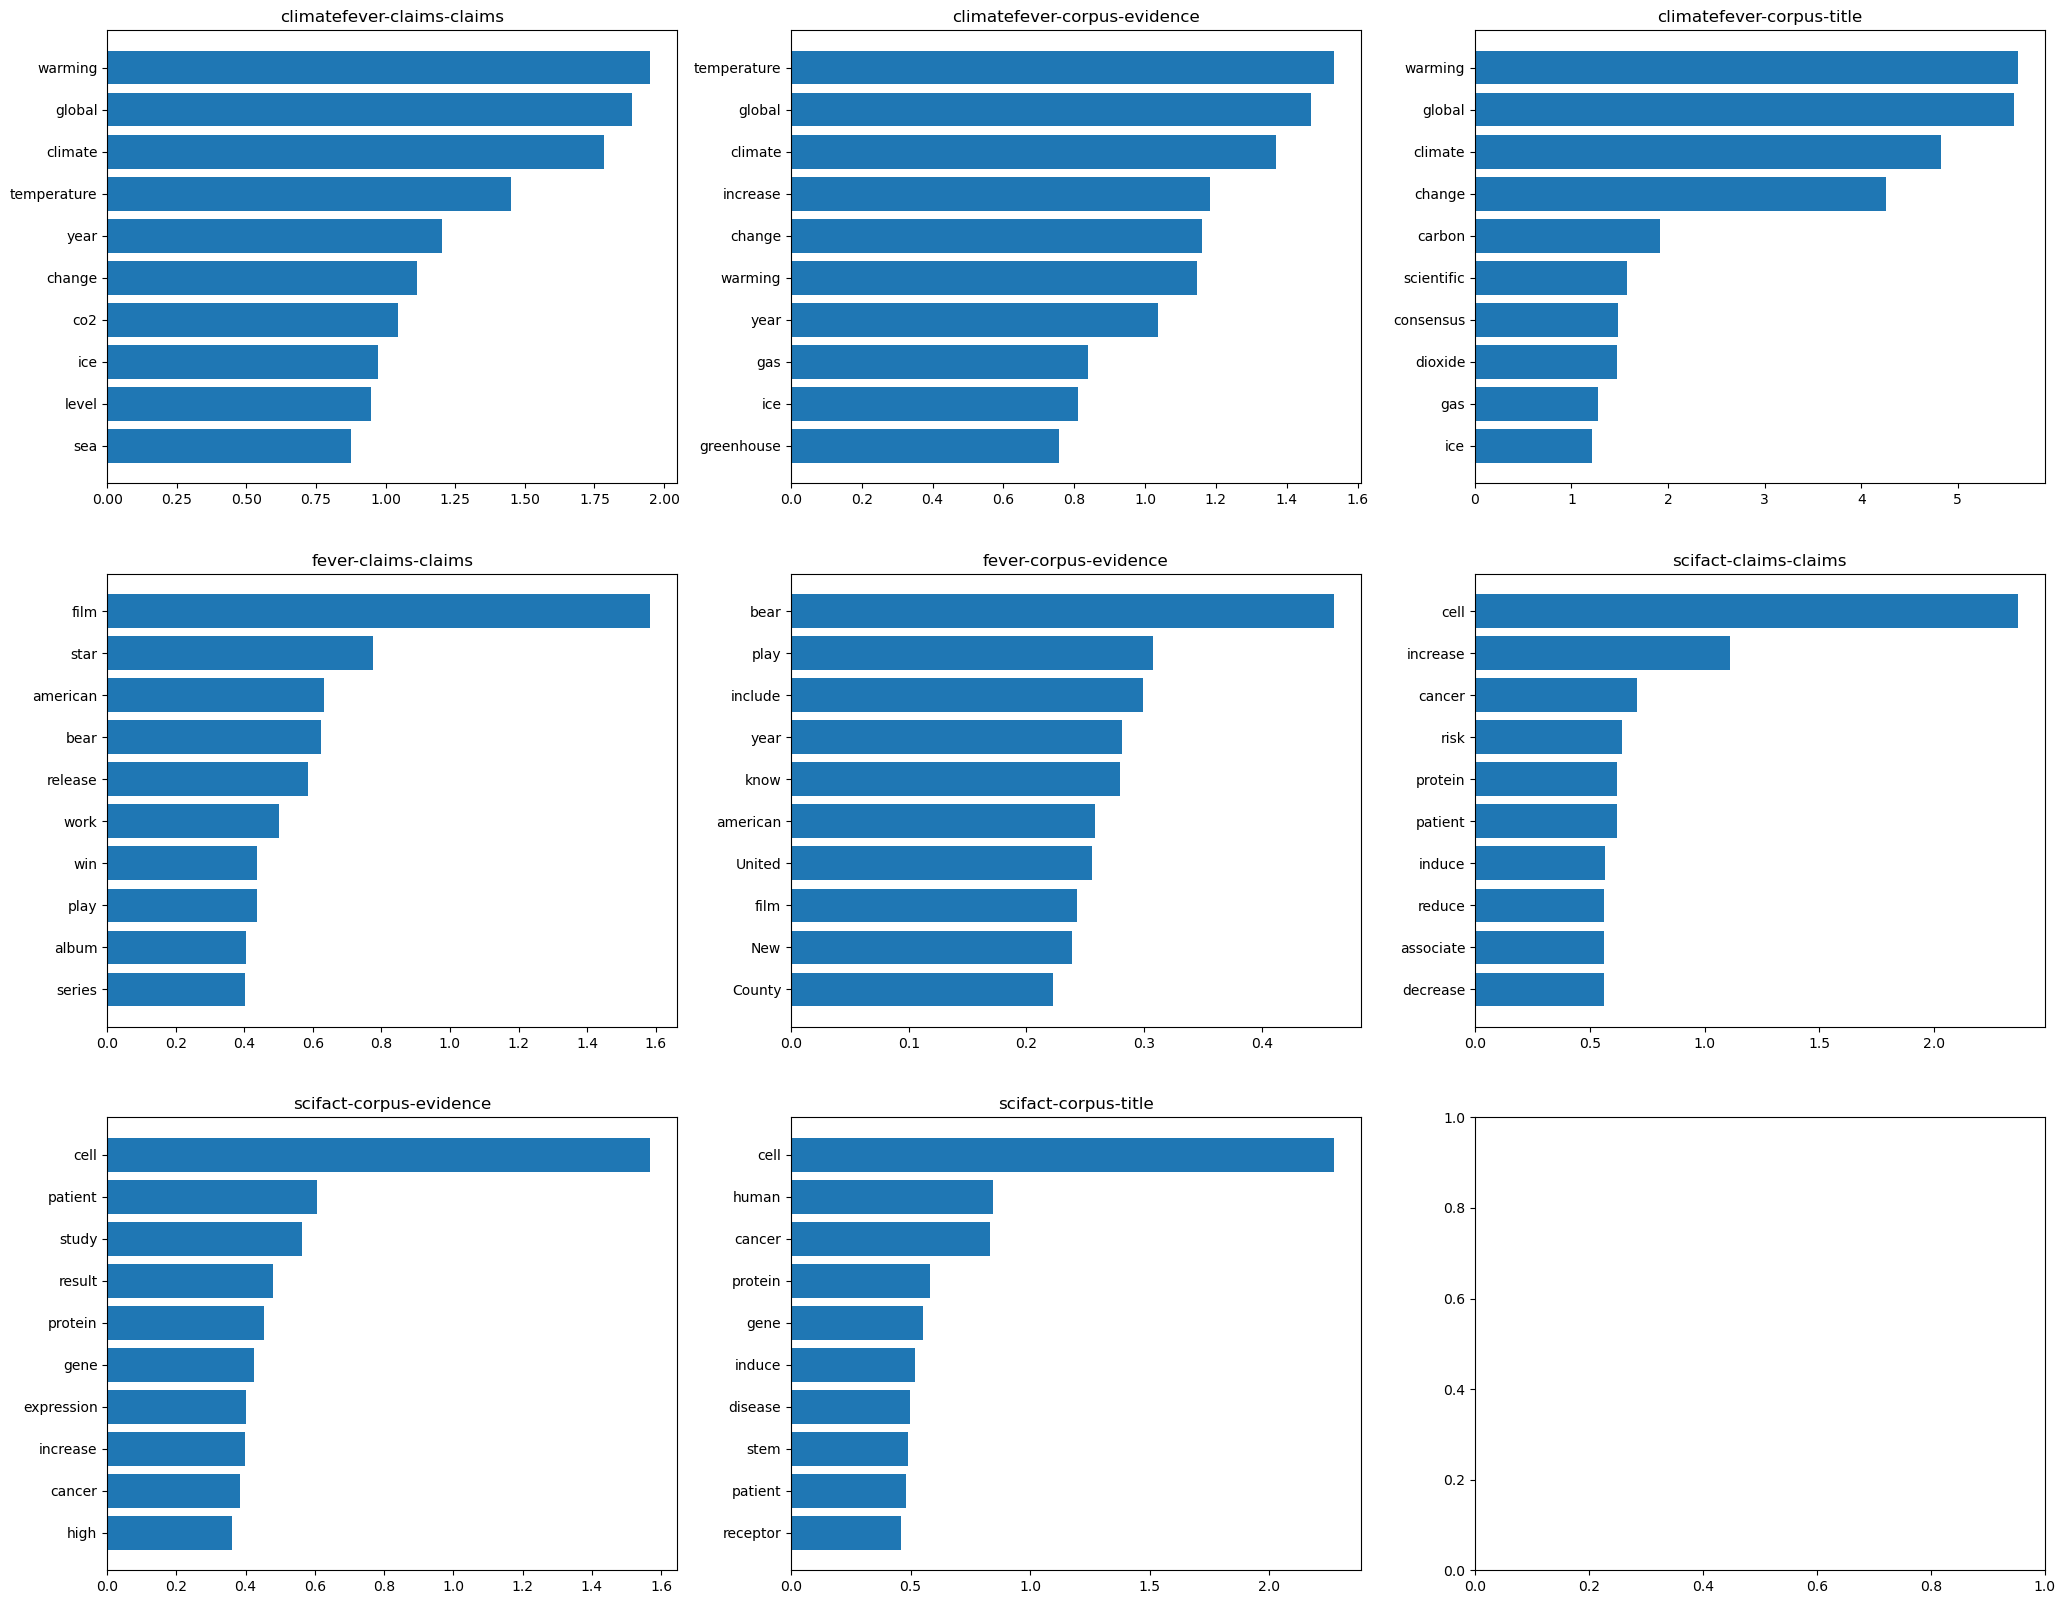

In [116]:
datasets = df_topwords["dataset"].unique()
cols = 3
rows = int(np.ceil(len(datasets)/cols))
fig, ax = plt.subplots(rows, cols, figsize=[25, 20])

datasets = iter(datasets)
term = False
for r in range(rows):
    if term:
        break
    for c in range(cols):
        try:
            d = next(datasets)
            df_tmp = df_topwords.loc[df_topwords["dataset"] == d, ["lemma", "normalised_count"]]
            df_tmp = df_tmp.sort_values("normalised_count", ascending=True)
        except StopIteration:
            term = True
            break
        ax[r][c].barh(y=df_tmp["lemma"], width=df_tmp["normalised_count"])
        ax[r][c].set_title(d)

## Dataset Similarity